# 1. Introducing Model Selection

In the previous mission, we worked to optimize our predictions by creating and selecting the features used to train our model. The other half of the optimization puzzle is to optimize the model itself— or more specifically, the algorithm used to train our model.

So far, we've been using the **logistic regression** algorithm to train our models, however there are hundreds of different machine learning algorithms from which we can choose. Each algorithm has different strengths and weaknesses, and so we need to select the algorithm that works best with our specific data— in this case our Kaggle competition.

The process of selecting the algorithm which gives the best predictions for your data is called **model selection**.

In this mission, we're going work with two new algorithms: k-nearest neighbors and random forests.

Before we begin, we'll need to import in the data. To save time, we have saved the features we created in the previous mission as CSV files, `train_modified.csv` and `holdout_modified.csv`.

In [7]:
import pandas as pd
import numpy

train = pd.read_csv('data/train_modified.csv')
holdout = pd.read_csv('data/holdout_modified.csv')

# 2. Training a Baseline Model

We're going to `train` our models using all the columns in the train dataframe. This will cause a small amount of overfitting due to collinearity (as we discussed in the previous mission), but having more features will allow us to more thoroughly compare algorithms.

So we have something to compare to, we're going to train a logistic regression model like in the previous two missions. We'll use cross validation to get a baseline score.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

all_X = train.drop(['Survived','PassengerId'],axis=1)
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy_lr = numpy.mean(scores)

print('Linear Regression Accuracy:', accuracy_lr)

Linear Regression Accuracy: 0.823891442515038


# 3. Training a Model using K-Nearest Neighbors

The logistic regression baseline model from the previous screen scored 82.4%.

|Model|Cross-validation score|Kaggle score|
|-----|----------------------|------------|
|Previous best Kaggle score  |82.3%|78.0%|
|Logistic regression baseline|82.4%||

The logistic regression algorithm works by calculating linear relationships between the features and the target variable and using those to make predictions. Let's look at an algorithm that makes predictions using a different method.

The **k-nearest neighbors** algorithm finds the observations in our training set most similar to the observation in our test set, and uses the average outcome of those 'neighbor' observations to make a prediction. The 'k' is the number of neighbor observations used to make the prediction.

The plots below shows three simple k-nearest neighbors models where there are two features shown on each axis, and two outcomes, red and green.

![Simple k-nearest-neighbors classification algorithm](images/knn_overview.svg)

- In the first plot, the value of k is 1, so the closest 1 neighbour to our gray dot is used, green, making the prediction **green**.
- In the second plot, the value of k is 3, so the closest 3 neighbours to our gray dot are used, green, making the prediction **red** (2 red vs 1 green).
- In the third plot, the value of k is 5, so the closest 5 neighbours to our gray dot are used, green, making the prediction **red** (3 red vs 2 green).

Just like it does for logistic regression, scikit-learn has a class that makes it easy to use k-nearest neighbors to make predictions, `neighbors.KNeighborsClassifier`.

Scikit-learn's use of object-oriented design makes it easy to substitute one model for another. The syntax to instantiate a `KNeighborsClassifier` is very similar to the syntax we use for logistic regression.

```python
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
```

The optional `n_neighbors` argument sets the value of k when predictions are made. The default value of `n_neighbors` is 5, but we're going to start by building a simple model that uses the closest neighbor to make our predictions.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(knn, all_X, all_y, cv=10)
accuracy_knn = numpy.mean(scores)

print('KNN Accuracy:', accuracy_knn)

KNN Accuracy: 0.7857382816933379


# 4. Exploring Different K Values

The k-nearest neighbors model we trained in the previous screen had an accuracy score of 78.6%, worse than our baseline score of 82.4%.

|Model|Cross-validation score|Kaggle score|
|-|-|-|
|Previous best Kaggle score|82.3%|78.0%|
|Logistic regression baseline|82.4%||
|K-nearest neighbors, `k == 1`|78.6%||

Besides pure model selection, we can vary the settings of each model— for instance the value of k in our k-nearest neighbors model. This is called **hyperparameter optimization**.

We can use a loop and Python's inbuilt [`range()` class](https://docs.python.org/3/library/stdtypes.html#range) to iterate through different values for `k` and calculate the accuracy score for each different value. We will only want to test odd values for `k` to avoid ties, where both 'survived' and 'died' outcomes would have the same number of neighbors.

This is the syntax we would use to get odd values between 1-7 from `range()`:

```python
>>>  for k in range(1,8,2):
...      print(k)
     1
     3
     5
     7
```

Note that we use the arguments `(1,8,2)` to get values between 1 and 7, since the created `range()` object contains numbers up to but not including the `8`.

Let's use this technique to calculate the accuracy of our model for values of k from 1-49, storing the results in a dictionary.

To make the results easier to understand, we'll finish by plotting the scores. We have provided a helper function, `plot_dict()` which you can use to easily plot the dictionary.

*Note that we expect this step to take a while to run, as we are training 250 models in total (10 cross validation models for each of 25 values of k).*

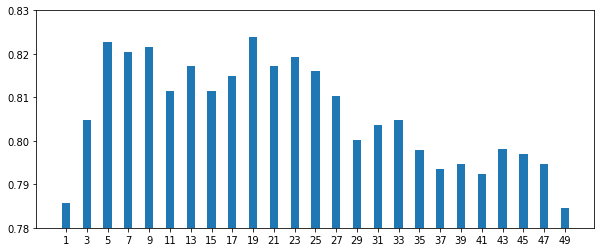

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

knn_scores = dict()

for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, all_X, all_y, cv=10)
    knn_scores[k] = numpy.mean(scores)
    
x_values = list(knn_scores.keys())
y_values = list(knn_scores.values())
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_ylim(0.78, 0.83)
ax.bar(x_values, y_values, align='center', tick_label=x_values)
plt.show()

# 5. Automating Hyperparameter Optimization with Grid Search

Looking at our plot from the previous screen we can see that a k value of 19 gave us our best score, and checking the knn_scores dictionary we can see that the score was 82.4%, identical to our baseline (if we didn't round the numbers you would see that it's actually 0.01% less accurate).

|Model|Cross-validation score|Kaggle score|
|-|-|-|
|Previous best Kaggle score	|82.3%	|78.0%|
|Logistic regression baseline	|82.4%|
|K-nearest neighbors, k == 1	|78.6%|
|K-nearest neighbors, k == 19	|82.4%|

The technique we just used is called **grid search** - we train a number of models across a 'grid' of values and then searched for the model that gave us the highest accuracy.

Scikit-learn has a class to perform grid search, `model_selection.GridSearchCV()`. The 'CV' in the name indicates that we're performing both grid search and cross validation at the same time.

By creating a dictionary of parameters and possible values and passing it to the `GridSearchCV` object you can automate the process. Here's what the code from the previous screen would look like, when implemented using the `GridSearchCV` class.

```python
from sklearn.model_selection import GridSearchCV
​
knn = KNeighborsClassifier()
​
hyperparameters = {
    "n_neighbors": range(1,50,2)
}
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)
​
print(grid.best_params_)
print(grid.best_score_)
```

Running this code will produce the following output:

```python
{'n_neighbors': 19}
0.82379349046
```

Our final step was to print the `GridSearchCV.best_params_` and `GridSearchCV.best_score_` attributes to retrieve the parameters of the best-performing model, and the score it achieved.

We can also use `GridSearchCV` to try combinations of different hyperparameters. Say we wanted to test values of `"ball_tree"`, `"kd_tree"`, and `"brute"` for the `algorithm` parameter and values of `1`, `3`, and `5` for the `n_neighbors` algorithm parameter. `GridSearchCV` would train and test 9 models (3 for the first hyperparameter times 3 for the second hyperparameter), shown in the diagram below.

![Grid Search](images/gridsearch.svg)

Let's use `GridSearchCV` to turbo-charge our search for the best performing parameters for our model, by testing 40 combinations of three different hyperparameters.

We have chosen the specific hyperparameters by consulting the documentation for the `KNeighborsClassifier` class.

In [56]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print('Best Params:', best_params)
print('Best Scores:', best_score)

Best Params: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best Scores: 0.8271604938271605


# 6. Submitting K-Nearest Neighbors Predictions to Kaggle

The cross-validation score for the best performing model was 82.7%, better than our baseline model.

|Model|Cross-validation score|Kaggle score|
|-|-|-|
|Previous best Kaggle score	|82.3%	|78.0%|
|Logistic regression baseline	|82.4%|
|K-nearest neighbors, k == 1	|78.6%|
|K-nearest neighbors, best model from grid search	|82.%|

We can use the `GridSearchCV.best_estimator_` attribute to retrieve a trained model with the best-performing hyperparameters. This code:

```python
best_knn = grid.best_estimator_
```

is equivalent to this code where we manually specify the hyperparameters and train the model:

```python
best_knn = KNeighborsClassifier(p=1,algorithm='brute',n_neighbors=5,weights='uniform')
best_knn.fit(all_X,all_y)
```

Lets use that model to make predictions on the holdout set and submit those predictions to Kaggle to see if we have improved overall.

In [57]:
holdout_no_id = holdout.drop(['PassengerId'],axis=1)
best_knn = grid.best_estimator_

holdout_predictions = best_knn.predict(holdout_no_id)
holdout_ids = holdout['PassengerId']
submission_df = {'PassengerId': holdout_ids, 'Survived': holdout_predictions}
submission = pd.DataFrame(submission_df)
# submission.to_csv('submission_1.csv', index=False)

# 7. Introducing Random Forests

When you submit this to Kaggle, you'll see it scores 75.6%, less than our best submission of 78.0%. While our model could be overfitting due to including all columns, it also seems like k-nearest neighbors may not be the best algorithm choice.

|Model|Cross-validation score|Kaggle score|
|-|-|-|
|Previous best Kaggle score	|82.3%	|78.0%|
|Logistic regression baseline	|82.4%|
|K-nearest neighbors, k == 1	|78.6%|
|K-nearest neighbors, best model from grid search	|82.%|75.6%|

Let's try another algorithm called **random forests**. Random forests is a specific type of **decision tree** algorithm. You have likely seen decision trees before as part of flow charts or infographics. Say we wanted to build a decision tree to help us [categorize an object as either being 'hotdog' or 'not hotdog'](https://www.youtube.com/watch?v=ACmydtFDTGs), we could construct a decision tree like the below:

![Decision Tree - Hotdog or Not Hotdog](images/decision_tree.svg)

Decision tree algorithms attempt to build the most efficient decision tree based on the training data, and then use that tree to make future predictions. Scikit-learn contains a class for classification using the random forest algorithm, `ensemble.RandomForestClassifier`. Here's how to fit a model and make predictions using the RandomForestClassifier class:

```python
from sklearn.ensemble import RandomForestClassifier
​
clf = RandomForestClassifier(random_state=1)
clf.fit(train_X,train_y)
predictions = clf.predict(test_X)
```

Because the algorithm includes randomization, we have to set the `random_state` parameter to make sure our results are reproducible.

Let's use a `RandomForestClassifier` object with `cross_val_score()` as we did earlier to see how the algorithm performs with the default hyperparameters.

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)
scores = cross_val_score(rf, all_X, all_y, cv=10)
accuracy_rf = numpy.mean(scores)

print('Random Forest Accuracy:', accuracy_rf)

Random Forest Accuracy: 0.8070125411417546


# 8. Tuning our Random Forests Model with GridSearch

Using the default settings, our random forests model obtained a cross validation score of 80.7%.

|Model|Cross-validation score|Kaggle score|
|-|-|-|
|Previous best Kaggle score	|82.3%	|78.0%|
|Logistic regression baseline	|82.4%|
|K-nearest neighbors, k == 1	|78.6%|
|K-nearest neighbors, best model from grid search	|82.%|75.6%|
|Random forests, default hyperparameters|80.7%|

Just like we did with the k-nearest neighbors model, we can use `GridSearchCV` to test a variety of hyperparameters to find the best performing model.

The best way to see a list of available hyperparameters is by checking the documentation for the classifier— in this case, [the documentation for `RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Let's use grid search to test out combinations of the following hyperparameters:

- `criterion`: `"entropy"` or `"gini"`
- `max_depth`: `5` or `10`
- `max_features`: `"log2"` or `"sqrt"`
- `min_samples_leaf`: `1` or `5`
- `min_samples_split`: `3` or `5`
- `n_estimators`: `6` or `9`

In [60]:
hyperparameters = {
    'criterion': ["entropy","gini"],
    'max_depth': [5,10],
    'max_features': ["log2","sqrt"],
    'min_samples_leaf': [1,5],
    'min_samples_split': [3,5],
    'n_estimators': [6,9]
}

rf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(rf, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)
best_params = grid.best_params_
best_score = grid.best_score_

print('Best Params:', best_params)
print('Best Score:', best_score)

Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}
Best Score: 0.8428731762065096


# 9. Submitting Random Forest Predictions to Kaggle

The cross-validation score for the best performing model was 84.3%, making it the best cross-validation score we've obtained in this mission.

|Model|Cross-validation score|Kaggle score|
|-|-|-|
|Previous best Kaggle score	|82.3%	|78.0%|
|Logistic regression baseline	|82.4%|
|K-nearest neighbors, k == 1	|78.6%|
|K-nearest neighbors, best model from grid search	|82.%|75.6%|
|Random forests, default hyperparameters|80.7%|
|Random forests, best model from grid search|84.3%|

In [61]:
# The `GridSearchCV` object is stored in memory from
# the previous screen with the variable name `grid`
best_rf = grid.best_estimator_
holdout_predictions = best_rf.predict(holdout_no_id)
holdout_ids = holdout['PassengerId']
submission_df = {'PassengerId': holdout_ids, 'Survived': holdout_predictions}
submission = pd.DataFrame(submission_df)
#submission.to_csv('submission_2.csv', index=False)

# 10. Next Steps

If you submit this to Kaggle, it achieves a score of 77.1%, considerably better than our k-nearest neighbors score of 75.6% and very close (2 incorrect predictions) to our best score from the previous mission of 78.0%

![Submission Rank](images/submission_rank_2.png)

|Model|Cross-validation score|Kaggle score|
|-|-|-|
|Previous best Kaggle score	|82.3%	|78.0%|
|Logistic regression baseline	|82.4%|
|K-nearest neighbors, k == 1	|78.6%|
|K-nearest neighbors, best model from grid search	|82.%|75.6%|
|Random forests, default hyperparameters|80.7%|
|Random forests, best model from grid search|84.3%|77.1%|

By combining our strategies for feature selection, feature engineering, model selection and model tuning, we'll be able to continue to improve our score.